#TIME SERIES ANALYSIS

#Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

##DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP. You can get it in the github repo as well as here: http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/MTA_Fare.npy. 

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


Each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/21/2010 to 02/21/2014. 

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

note that the missing values are inputted as -1

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

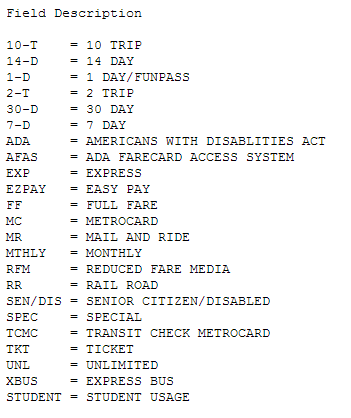

In [2]:
from IPython.display import Image
Image(filename = "Ridetypes.png")

In [3]:
mta = np.load('MTA_Fare.npy').astype('float')
#after reading the datacube you should see:
print mta.shape

(600, 23, 194)


In [4]:
#ride types list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

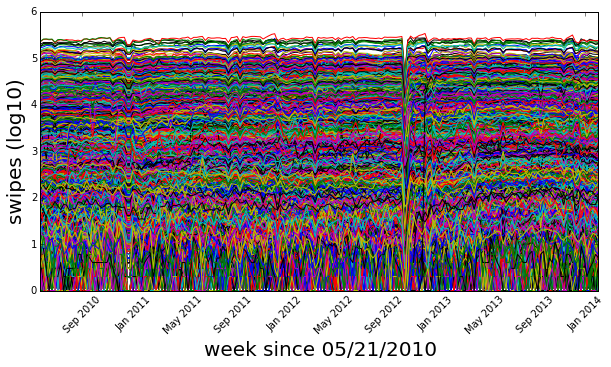

In [5]:
mta[mta == -1] = np.nan
#create a date range
date = pd.date_range('20100521', periods=194, freq='W')

#plot all time series, each station and each ride type
#use log plot to enhance the visibility along the y axis 
ax1 = plt.figure(figsize = (10,5))
for i in range (mta.shape[0]):
    for j in range (mta.shape[1]):
        plt.plot(date, np.log10(mta[i][j])) 
plt.xticks(rotation=45)
plt.xlabel("week since 05/21/2010", fontsize = 20)
plt.ylabel("swipes (log10)", fontsize = 20)

#Task 1: 
##Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
##Identify it and figure out what it is due to.

In [6]:
print mta.shape
#sum time series for all stations
sum1 = pd.DataFrame(np.nansum(mta, axis=0))
print (sum1.shape)
#sum time series for all stations and all card types
sum2 = pd.DataFrame(np.nansum(sum1, axis=0), index=date, columns=['count'])
print (sum2.shape)

(600, 23, 194)
(23, 194)
(194, 1)


In [7]:
thresholds = [sum2['count'].mean() + 3*sum2['count'].std(), 
              sum2['count'].mean() - 3*sum2['count'].std()]
print thresholds

[38756392.57537587, 20806307.16689217]


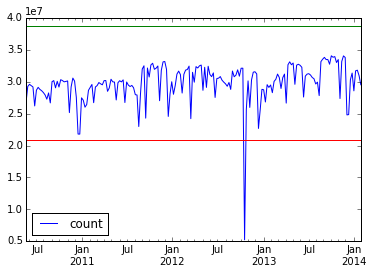

In [8]:
ax2 = sum2.plot()
ax2.plot([ax2.get_xlim()[0], ax2.get_xlim()[1]], [thresholds[0], thresholds[0]])
ax2.plot([ax2.get_xlim()[0], ax2.get_xlim()[1]], [thresholds[1], thresholds[1]])

In [9]:
sum2.loc[(sum2['count']<thresholds[1])]

,count
2012-10-21,5218686


## Answer to Task 1
###The most prominent event happenned on October 21th 2012, which is due to the Hurrican Sandy.

#Task 2: 
##Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

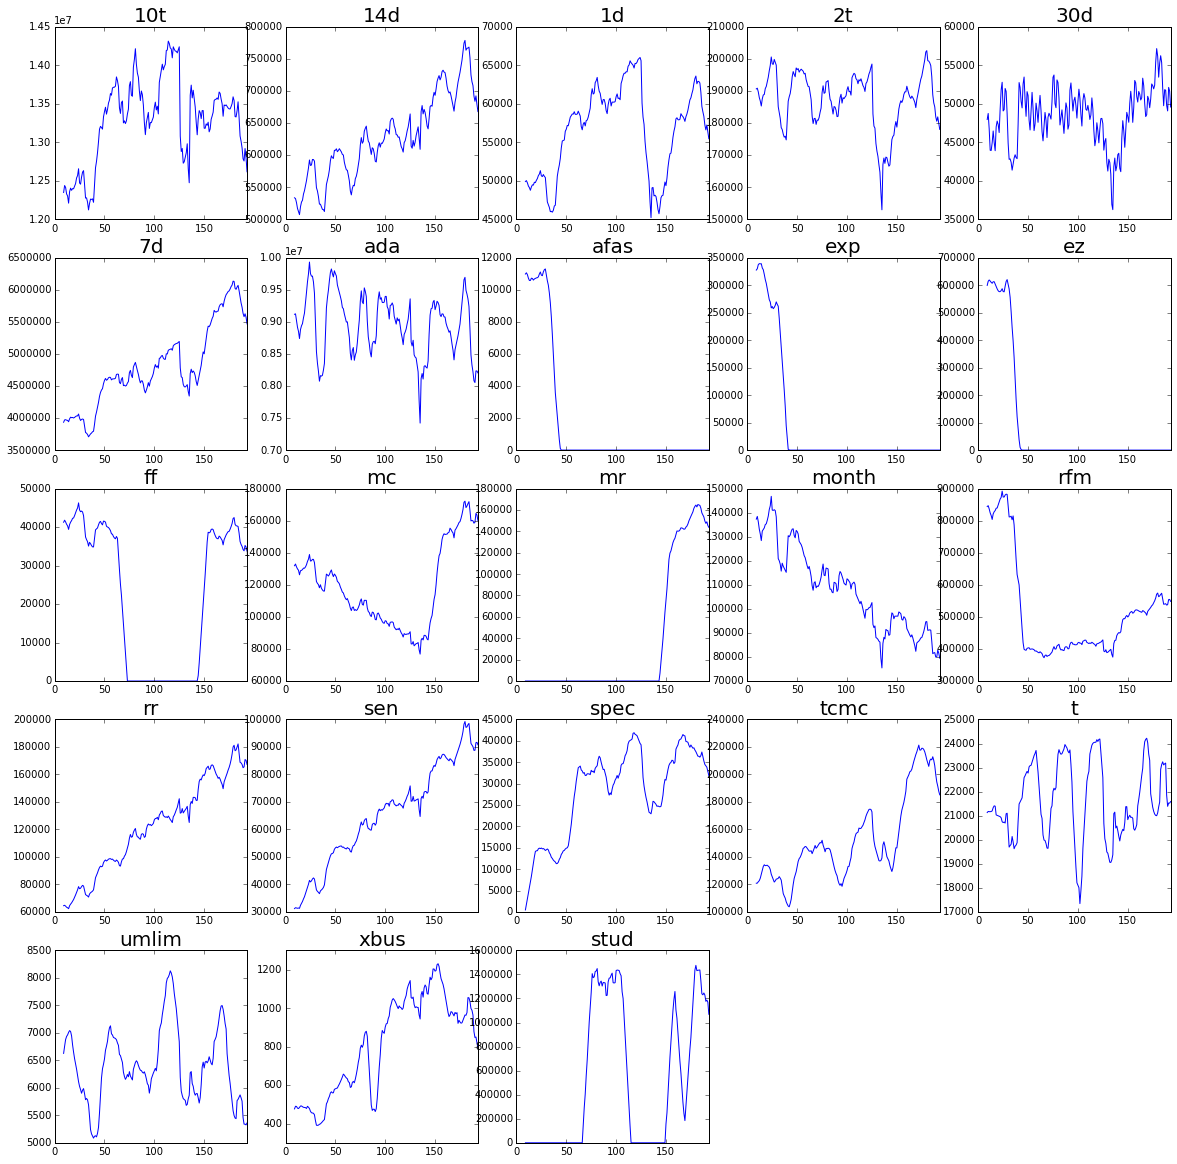

In [10]:
#Since the question is about "which rideship type", 
#we sum or average over the stations and reduce the data by a factor 600, which is what we did in sum1
fig = plt.figure(figsize = (20,20))
for i in range(23):
    roll_mean = pd.rolling_mean(sum1.loc[i], 10)
    ax = fig.add_subplot(5,5,i+1)
    ax = roll_mean.plot()
    ax.set_title(ridetype[i],fontsize=20)

In [11]:
ratio = np.zeros(23)
for i in range(23):
    roll_mean = pd.rolling_mean(sum1.loc[i], 10)
    ratio[i] = roll_mean.loc[193]/roll_mean.loc[9]
    print "Ride type: {0:} | ratio:{1:.2f}".format(ridetype[i], ratio[i])

Ride type: 10t | ratio:1.02
Ride type: 14d | ratio:1.25
Ride type: 1d | ratio:1.11
Ride type: 2t | ratio:0.93
Ride type: 30d | ratio:1.03
Ride type: 7d | ratio:1.39
Ride type: ada | ratio:0.90
Ride type: afas | ratio:0.00
Ride type: exp | ratio:0.00
Ride type: ez | ratio:0.00
Ride type: ff | ratio:0.82
Ride type: mc | ratio:1.21
Ride type: mr | ratio:24784.93
Ride type: month | ratio:0.58
Ride type: rfm | ratio:0.65
Ride type: rr | ratio:2.59
Ride type: sen | ratio:2.91
Ride type: spec | ratio:70.18
Ride type: tcmc | ratio:1.53
Ride type: t | ratio:1.02
Ride type: umlim | ratio:0.81
Ride type: xbus | ratio:1.66
Ride type: stud | ratio:inf


## Answer to Task 2
###By looking at the output above we could conclude that spec(70.18), sen(2.91), and rr(2.59) are stabely increasing in popularity; while month(0.58), rfm(0.65) and umlim(0.81) are stabely decreasing in popularity.


#Task 3:
##Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)


In [12]:
# Since the question is about "which sation", 
# we sum or average over the stations and reduce the data by a factor 23
sum3 = pd.DataFrame(np.nansum(mta, axis=1)).transpose()
print (sum3.shape)

(194, 600)


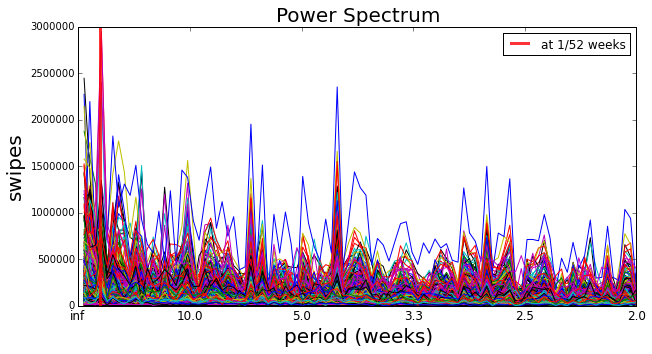

In [13]:
fig=plt.figure(figsize=(10,5))
N = 194
for i in range(599):
    freq = np.abs(np.fft.rfft(sum3[i+1]))
    ax=fig.add_subplot(111)
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (freq[1:]), '-');
plt.xlabel("period (weeks)", fontsize=20)
plt.ylabel("swipes", fontsize=20)
plt.ylim([0, 3e6])
plt.title("Power Spectrum", fontsize=20)
ax.set_xticklabels([ "{:.1f}".format(1/f) for f in ax.get_xticks()], fontsize=12)
plt.axvline(1.0/52,lw=3, color='red', label='at 1/52 weeks',alpha=0.8)
plt.legend()

In [14]:
station = []
power = []
for i in range(599):
    x = (np.abs(np.fft.rfft(sum3[i],)[1:]))
    station.append(i)
    power.append(x[3])

In [15]:
df = pd.DataFrame({'station':station,'power':power})
df.sort_values('power', ascending=0).head(4)

,power,station
0,2980160.635595,0
194,2950388.929214,194
150,2931895.876951,150
327,2402218.580959,327


## Answer to Task 3
###The 4 stations that show the most prominent periodic trend on an annual period are station 0, 194, 150 and 327.